# Cumulative Variance Explained by Top Singular Vectors

This notebook plots the cumulative variance captured by the top-k singular vectors of the penultimate layer embeddings.

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Add parent directory to path to import training module
sys.path.insert(0, os.path.dirname(os.getcwd()))

from DD_R32_D48_training import (
    ReLUNetwork,
    create_task_matrix,
    generate_data,
    get_penultimate_embeddings,
    device,
    CHECKPOINTS_DIR,
)

# Configuration
CHECKPOINT_PATH = os.path.join(CHECKPOINTS_DIR, "DD_R32_D48_model_epoch_300000.pt")
RANK = 32
DEPTH = 48
DIM = 64
N_SAMPLES = 128
SEED = 42

In [17]:
# Load the trained model
checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
model = ReLUNetwork(dim=DIM, depth=DEPTH)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print(f"Loaded model from epoch {checkpoint['epoch']}")

# Create data (same as training)
W = create_task_matrix(DIM, RANK, seed=SEED)
X, Y = generate_data(W, N_SAMPLES, seed=SEED + 1)

# Get penultimate layer embeddings
embeddings = get_penultimate_embeddings(model, X)
print(f"Embeddings shape: {embeddings.shape}")

In [18]:
# Compute SVD of embeddings
U, S, Vh = torch.linalg.svd(embeddings, full_matrices=False)

# Compute variance (squared singular values)
variance = S**2
total_variance = variance.sum()

# Cumulative variance explained
cumulative_variance = torch.cumsum(variance, dim=0) / total_variance * 100

print(f"Number of singular values: {len(S)}")
print(f"\nTop 10 singular values: {S[:10].tolist()}")
print(f"\nCumulative variance explained:")
for k in [1, 2, 3, 5, 10, 20, 32, 64]:
    if k <= len(cumulative_variance):
        print(f"  Top-{k}: {cumulative_variance[k - 1]:.1f}%")

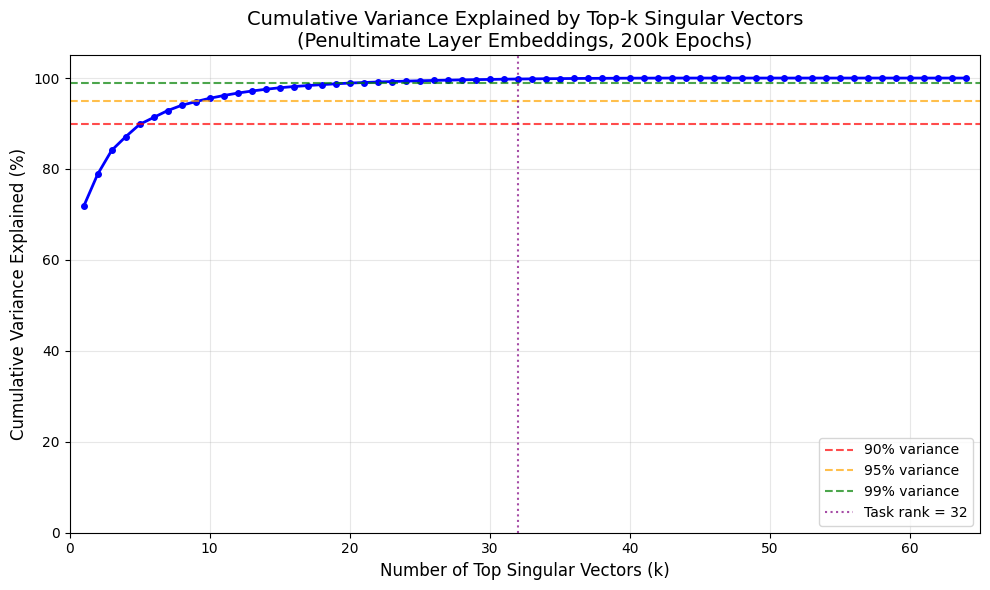

In [5]:
# Plot cumulative variance
fig, ax = plt.subplots(figsize=(10, 6))

k_values = np.arange(1, len(cumulative_variance) + 1)
cum_var = cumulative_variance.numpy()

ax.plot(k_values, cum_var, "b-o", markersize=4, linewidth=2)

# Reference lines
ax.axhline(y=90, color="r", linestyle="--", alpha=0.7, label="90% variance")
ax.axhline(y=95, color="orange", linestyle="--", alpha=0.7, label="95% variance")
ax.axhline(y=99, color="g", linestyle="--", alpha=0.7, label="99% variance")

# Mark task rank
ax.axvline(
    x=RANK, color="purple", linestyle=":", alpha=0.7, label=f"Task rank = {RANK}"
)

ax.set_xlabel("Number of Top Singular Vectors (k)", fontsize=12)
ax.set_ylabel("Cumulative Variance Explained (%)", fontsize=12)
ax.set_title(
    "Cumulative Variance Explained by Top-k Singular Vectors\n(Penultimate Layer Embeddings, 200k Epochs)",
    fontsize=14,
)
ax.legend(loc="lower right")
ax.grid(True, alpha=0.3)
ax.set_xlim(0, len(k_values) + 1)
ax.set_ylim(0, 105)

plt.tight_layout()
plt.savefig("variance_spectrum.png", dpi=150)
plt.show()

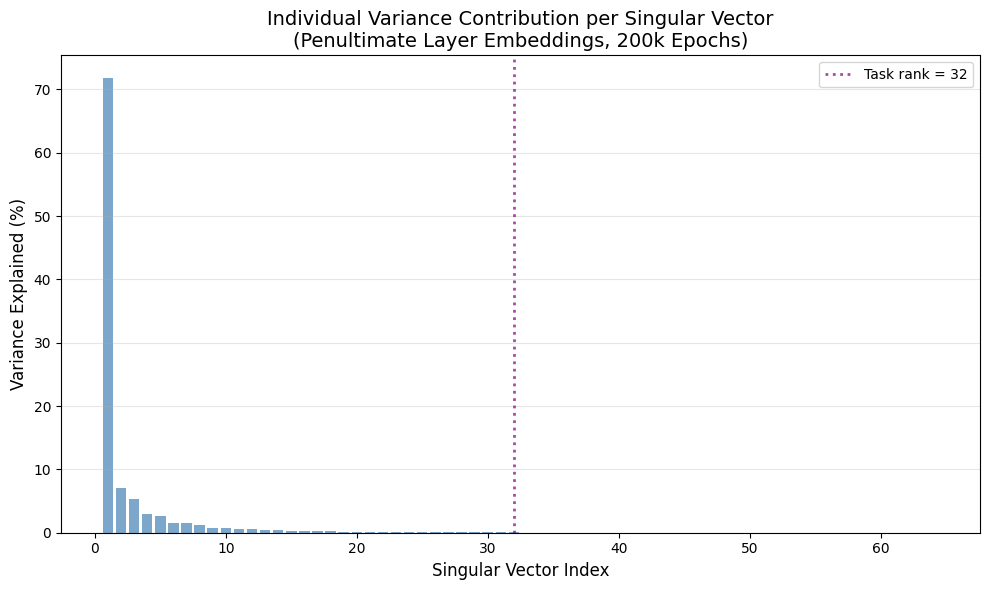

In [6]:
# Plot individual variance contribution (not cumulative)
fig, ax = plt.subplots(figsize=(10, 6))

individual_variance = (variance / total_variance * 100).numpy()

ax.bar(k_values, individual_variance, color="steelblue", alpha=0.7)

ax.axvline(
    x=RANK,
    color="purple",
    linestyle=":",
    alpha=0.7,
    linewidth=2,
    label=f"Task rank = {RANK}",
)

ax.set_xlabel("Singular Vector Index", fontsize=12)
ax.set_ylabel("Variance Explained (%)", fontsize=12)
ax.set_title(
    "Individual Variance Contribution per Singular Vector\n(Penultimate Layer Embeddings, 200k Epochs)",
    fontsize=14,
)
ax.legend()
ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.savefig("variance_individual.png", dpi=150)
plt.show()

print(f"\nTop singular vector explains {individual_variance[0]:.1f}% of variance")
print(f"This indicates severe rank collapse in the learned representation.")

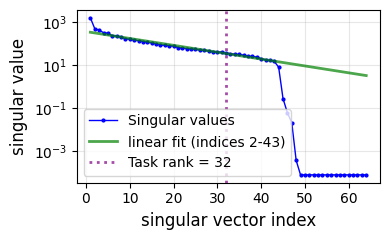

In [7]:
# Log-scale singular value spectrum
fig, ax = plt.subplots(figsize=(4, 2.5))

ax.semilogy(
    k_values, S.numpy(), "b-o", markersize=2, linewidth=1, label="Singular values"
)

# Fit a straight line to indices 2 to 43
fit_indices = np.arange(1, 42)  # indices 2 to 43 (0-indexed: 1 to 41)
S_fit = S.numpy()[fit_indices]
k_fit = k_values[fit_indices]

# Fit in log space: log(S) = a + b*k
log_S = np.log(S_fit)
coeffs = np.polyfit(k_fit, log_S, 1)
b, a = coeffs  # slope and intercept

# Extend the fit line across the full range of singular values
k_full = k_values
fitted_log_S_full = a + b * k_full
fitted_S_full = np.exp(fitted_log_S_full)

ax.semilogy(
    k_full,
    fitted_S_full,
    "g-",
    linewidth=2,
    alpha=0.7,
    label="linear fit (indices 2-43)",
)

ax.axvline(
    x=RANK,
    color="purple",
    linestyle=":",
    alpha=0.7,
    linewidth=2,
    label=f"Task rank = {RANK}",
)

ax.set_xlabel("singular vector index", fontsize=12)
ax.set_ylabel("singular value", fontsize=12)
# ax.set_title('Singular Value Spectrum of Penultimate Layer Embeddings\n(200k Epochs)', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("singular_value_spectrum.png", dpi=150)
plt.show()

print(f"\nSingular value ratio S[0]/S[1]: {S[0] / S[1]:.2f}")
print(f"Singular value ratio S[0]/S[{RANK - 1}]: {S[0] / S[RANK - 1]:.2f}")
print(f"\nLinear fit in log-space (indices 2-43):")
print(f"  log(S) = {a:.4f} + {b:.4f} * k")
print(f"  Slope: {b:.4f} (decay rate in log scale)")

In [22]:
# Summary table
summary = "=" * 60 + "\n"
summary += "VARIANCE SPECTRUM SUMMARY\n"
summary += "=" * 60 + "\n"

summary += f"\nModel: {DEPTH}-layer ReLU MLP, dim={DIM}\n"
summary += f"Task rank: {RANK}\n"
summary += f"Training epochs: {checkpoint['epoch']}\n"

# Convert cumulative_variance to numpy for easier access
cum_var_np = cumulative_variance.numpy()

summary += f"\nCumulative variance explained:\n"
summary += f"  Top-1:  {cum_var_np[0]:.1f}%\n"
summary += f"  Top-2:  {cum_var_np[1]:.1f}%\n"
summary += f"  Top-3:  {cum_var_np[2]:.1f}%\n"
summary += f"  Top-5:  {cum_var_np[4]:.1f}%\n"
summary += f"  Top-10: {cum_var_np[9]:.1f}%\n"
summary += f"  Top-20: {cum_var_np[19]:.1f}%\n"
summary += f"  Top-32: {cum_var_np[31]:.1f}%\n"

# Find how many components needed for 90%, 95%, 99%
for threshold in [90, 95, 99]:
    k_needed = (cumulative_variance >= threshold).nonzero()[0][0].item() + 1
    summary += f"\nComponents needed for {threshold}% variance: {k_needed}\n"

summary += "\n" + "=" * 60

print(summary)
summary

'============================================================\nVARIANCE SPECTRUM SUMMARY\n============================================================\n\nModel: 48-layer ReLU MLP, dim=64\nTask rank: 32\nTraining epochs: 300000\n\nCumulative variance explained:\n  Top-1:  71.8%\n  Top-2:  78.9%\n  Top-3:  84.1%\n  Top-5:  89.8%\n  Top-10: 95.6%\n  Top-20: 98.9%\n  Top-32: 99.8%\n\nComponents needed for 90% variance: 6\n\nComponents needed for 95% variance: 10\n\nComponents needed for 99% variance: 21\n\n============================================================'